<a href="https://colab.research.google.com/github/gabrielletaree/Clustering-Exploration/blob/main/Clustering%20Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NO1

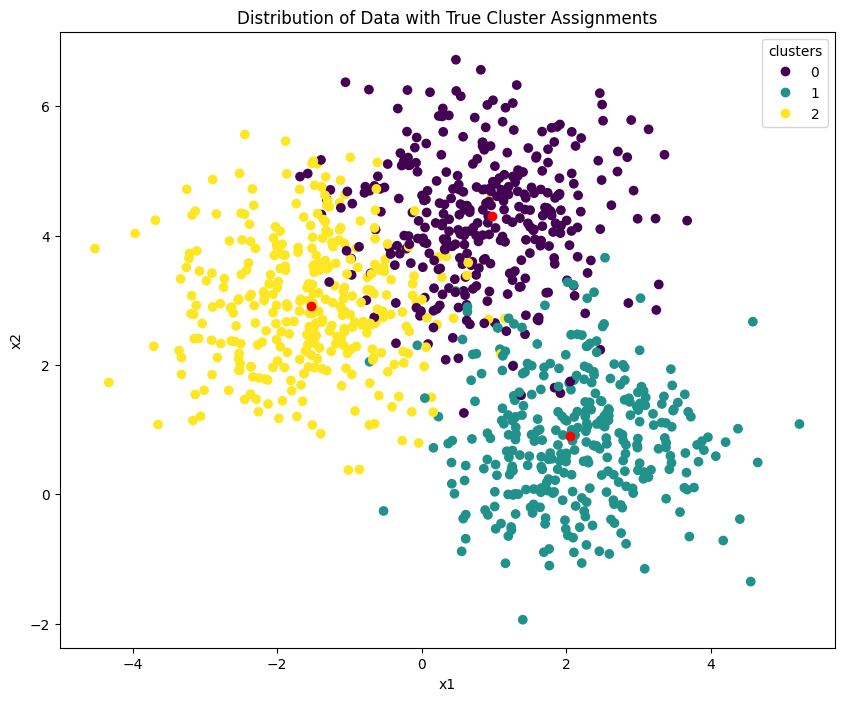

In [ ]:
#@title Contoh 1: Membuat Algoritma k-Means Clustering
# imports
import numpy as np
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """
    def __init__(self, K: int=3, n_init: int=20, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance
        Inputs:
        K -> integer number of clusters to assign
        n_init -> integer number of times the algorithm will be applied when training
        max_iters -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters

    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters

    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
        numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
        list of numpy arrays of centroid for cluster, each array with shape: [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X : np.array, cluster_assignment : np.array, centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:], X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)

    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
        numpy array of centroids with shape: [K, number_features]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS
        Inputs:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf
        # loop over all iterations requested
        for _ in range(self.n_init):
            # initialise centroids
            centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration = 0
            while (not np.array_equal(centroid_diff, np.zeros(self.K))) and iteration < self.max_iters:
                # assign samples to clusters
                cluster_assignment = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, cluster_assignment)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration += 1
                old_centroids = np.copy(centroids)
            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids

    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids
        Input:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
        numpy

 array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)

    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)

    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)
        Output:
        numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids

    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K, 'n_init':self.n_init, 'max_iters':self.max_iters}

# Memproduksi dataset
X, y, centers = make_blobs(n_samples=1000, centers=3, n_features=2, return_centers=True, random_state=0)

# visualise data
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y)
sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

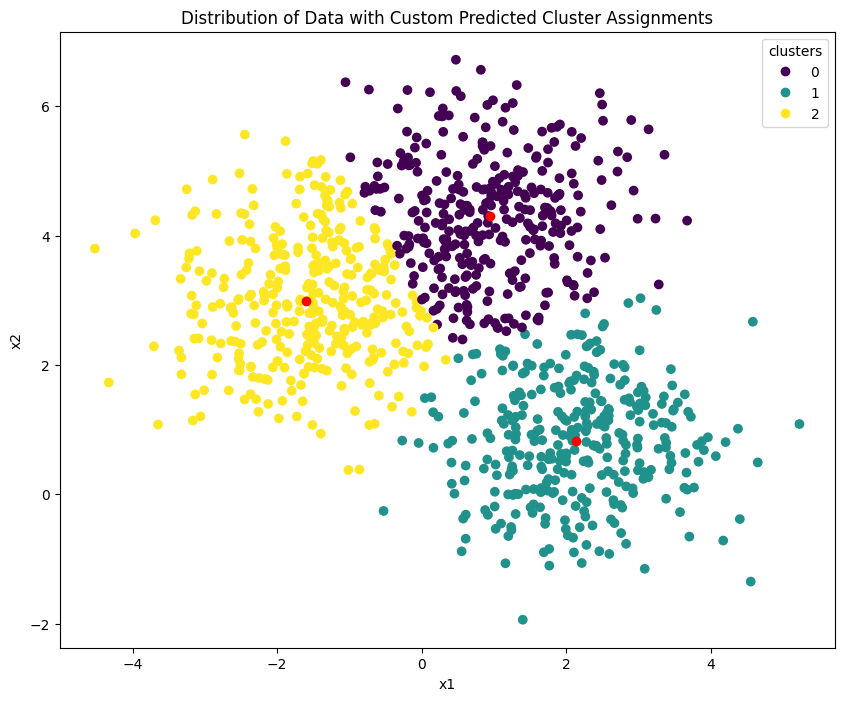

In [ ]:
#@title Contoh 2: Menerapkan Algoritma k-Means Clustering
# Buat model KMeans
clt = KMeans(max_iters=300)

# Cocokkan model dengan data
clt.fit(X)

# Dapatkan prediksi
y_pred = clt.predict(X)

# Dapatkan prediksi sentroid
centers_pred = clt.return_centroids()

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Custom Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [ ]:
#@title Contoh 3: Menilai Performa Algoritma k-Means Clustering
# Mendapatkan nilai cluster errors
clt.return_wcss()

# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[2,0,1]])}')

# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 2
y_pred[idx_1] = 0
y_pred[idx_2] = 1

# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 2.3614310165778916
Accuracy score: 0.0330
Precision score: 0.0333
Recall score: 0.0330
F1 score: 0.0332


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


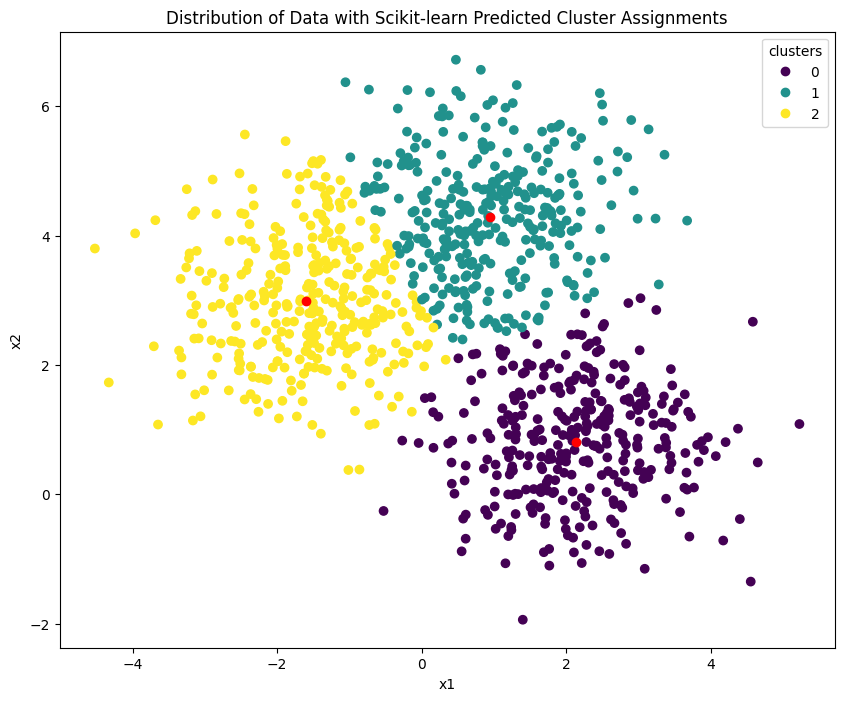

In [ ]:
#@title Contoh 4: Menerapkan Algoritma k-Means Clustering (Menggunakan Library ScikitLearn)
# import scikit-learn K-Means
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y, centers = make_blobs(n_samples=1000, centers=3, n_features=2, return_centers=True, random_state=0)

# Buat model KMeans
clt = KMeans(n_clusters=3, max_iter=300, random_state=0)

# Cocokkan model dengan data
clt.fit(X)

# Dapatkan prediksi
y_pred = clt.predict(X)

# Dapatkan prediksi sentroid
centers_pred = clt.cluster_centers_

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [ ]:
#@title Contoh 5: Menilai Algoritma k-Means Clustering (Menggunakan Library ScikitLearn)
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[1,0,2]])}')

# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 1
y_pred[idx_1] = 0
y_pred[idx_2] = 2

# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 0.05823172077110224
Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


#No 2

In [ ]:
!gdown https://drive.google.com/uc?id=19tCftXkMCD1AYQB6zFHXxAhyYTJb-8sb &> /dev/null
!unzip /content/air+quality.zip &> /dev/null
!rm /content/air+quality.zip &> /dev/null

In [ ]:
import pandas as pd

df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', encoding='latin1')
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[2 2 2 ... 3 3 3]


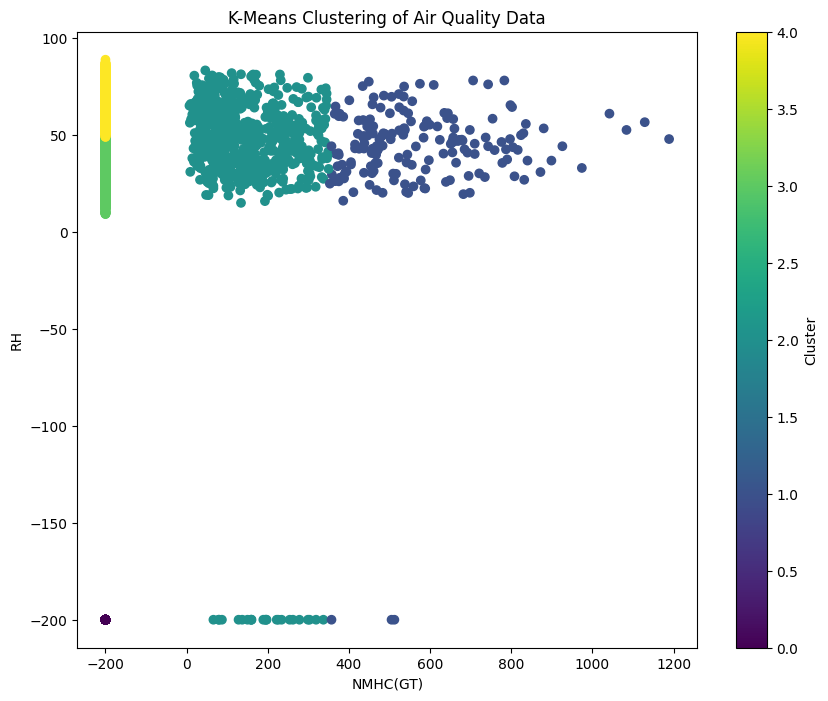

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict


# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """
    def __init__(self, K: int=5, n_init: int=20, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance
        Inputs:
        K -> integer number of clusters to assign
        n_init -> integer number of times the algorithm will be applied when training
        max_iters -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters

    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.t
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters

    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        centroids -> numpy array of centroids with shape: [t, number_features]
        Output:
        numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
        list of numpy arrays of centroid for cluster, each array with shape: [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X : np.array, cluster_assignment : np.array, centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:], X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)

    def __update_centroids(self, X: np.array, cluster_assignment: np.array) -> np.array:
      """
      Private function to update cluster centroids
      Inputs:
      X -> numpy array of input features with shape: [number_samples, number_features]
      cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
      Output:
      numpy array of centroids with shape: [K, number_features]
      """
      # break up the input features according to their cluster assignments
      X_clusters = self.__partition_data(X, cluster_assignment)

      new_centroids = []
      for i in range(self.K):
          if i < len(X_clusters):
              cluster_samples = X_clusters[i]
              if len(cluster_samples) > 0:
                  new_centroid = np.mean(cluster_samples, axis=0)
                  new_centroids.append(new_centroid)
              else:
                  # If the cluster is empty, use a random sample as the centroid
                  new_centroids.append(X[np.random.choice(X.shape[0])])
          else:
              # If there are fewer clusters than self.K, use a random sample as the centroid
              new_centroids.append(X[np.random.choice(X.shape[0])])

      return np.array(new_centroids)




    def fit(self, X: np.array) -> None:
      """
      Training function for the class. Aims to find the optimal centroid values that minimise the WCSS
      Inputs:
      X -> numpy array of input features of assumed shape [number_samples, number_features]
      """
      # initialize wcss score
      self.total_wcss = np.inf

      # loop over all iterations requested
      for _ in range(self.n_init):
          # initialize centroids
          centroids = X[np.random.choice(X.shape[0], self.K, replace=False), :]

          old_centroids = np.copy(centroids)

          # loop through the K-Means learning algorithm
          centroid_diff = np.ones((self.K))
          iteration = 0

          while (not np.array_equal(centroid_diff, np.zeros(self.K))) and iteration < self.max_iters:
              # assign samples to clusters
              cluster_assignment = self.__assign_samples(X, centroids)

              # update centroids
              centroids = self.__update_centroids(X, cluster_assignment)

              # compute difference between centroids
              centroid_diff = np.abs(old_centroids - centroids)

              # increment counter & reset old_centroids
              iteration += 1
              old_centroids = np.copy(centroids)

          # compute WCSS for the resulting clusters
          total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)

          # check if we have a new optimal centroid configuration?
          if total_wcss < self.total_wcss:
              # if so, update storage objects
              self.total_wcss = total_wcss
              self.wcss_array = wcss_array
              self.centroids = centroids


    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids
        Input:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
        numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)

    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)

    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)
        Output:
        numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids

    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K, 'n_init':self.n_init, 'max_iters':self.max_iters}

# Memuat dataset AirQualityUCI.csv
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', encoding='latin1')
# Hanya menggunakan beberapa kolom sebagai contoh
selected_columns = ['NMHC(GT)', 'RH']
df_selected = df[selected_columns].dropna()

# Menggunakan fitur yang sesuai
X = df_selected.values

# Membuat dan melatih model KMeans
kmeans = KMeans(K=5)
kmeans.fit(X)

# Memprediksi cluster untuk setiap sampel
predictions = kmeans.predict(X)

# Menampilkan hasil prediksi
print(predictions)

# Visualisasi hasil clustering
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(X[:, 0], X[:, 1], c=predictions, cmap='viridis')
plt.xlabel('NMHC(GT)')
plt.ylabel('RH')
plt.title('K-Means Clustering of Air Quality Data')
plt.colorbar(sc, label='Cluster')
plt.show()

#NO 3

In [ ]:
import pandas as pd

df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', encoding='latin1')
df.drop(columns=df.columns[-2:], inplace=True)
df.dropna(inplace=True)
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


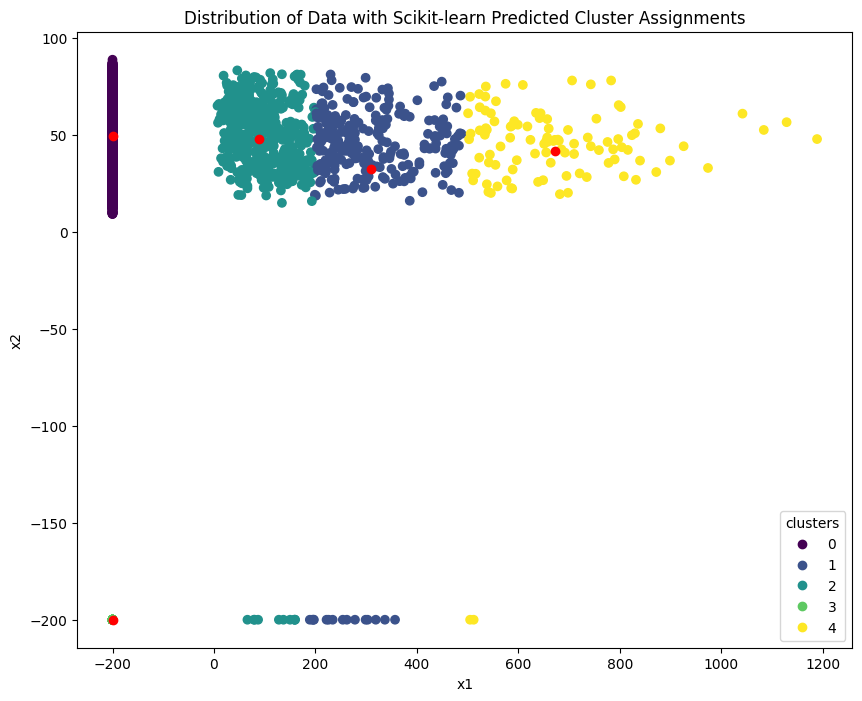

In [ ]:
# import scikit-learn K-Means
from sklearn.cluster import KMeans
import pandas as pd

df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', encoding='latin1')
df.drop(columns=df.columns[-2:], inplace=True)
df.dropna(inplace=True)
df

X = df[['NMHC(GT)', 'RH']]

# Buat model KMeans
clt = KMeans(n_clusters=5, max_iter=300, random_state=0)

# Cocokkan model dengan data
clt.fit(X)

# Dapatkan prediksi
y_pred = clt.predict(X)

# Dapatkan prediksi sentroid
centers_pred = clt.cluster_centers_

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X.iloc[:,0],X.iloc[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [ ]:
#@title Contoh 5: Menilai Algoritma k-Means Clustering (Menggunakan Library ScikitLearn)
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[1,0,2]])}')

# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 1
y_pred[idx_1] = 0
y_pred[idx_2] = 2

# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 120.17094851104383


ValueError: ignored